# Imagenet Pipeline Profiling Analysis

### Prerequisites

None. Exemplary logs are loaded by default. Experiments were run on:

* Storage: CEPH HDD
* CPU: Intel Xeon E5-2630 v3 8x@2.4GHz
* Image: ubuntu-18.04-lts/Openstack
* Memory: 80GB DDR4

All plots that are not saved with the `save_fig` function were not used in the paper, but may provide a close-up look on specific values.

### Meta information

* "first" preprocessing step of listing the files was removed (check `imagenet_demo.py`) because it did not affect performance in our tests. This should be reintroduced when simulating distributed training, e.g., federated learning, where getting the file locations can actually affect performance

* Dataset size: `146.899991342 GB` (`imagenet/ILSVRC/Data/CLS-LOC/train> du -hb .` / 1000 / 1000)
* Amount of `.JPEG` files: `1281167` (`imagenet/ILSVRC/Data/CLS-LOC/train> find . -name "*.JPEG" | wc -l`)
* Avg. filesize: `0.11466107957978935 MB`
* Avg. resolution (Imagenet paper): `400x350`
* Sample sizes (rounded to second decimal):
    * `   0500:        57.33 MB` 
    * `   1000:       114.66 MB`
    * `   2000:       229.32 MB`
    * `   4000:       458.64 MB`
    * `   8000:       917.29 MB`
    * `1281167: 146899.99 MB` 

In [1]:
full_dataset_samplecount = 1281167
for sample_size in [500, 1000, 2000, 4000, 8000]:
    print(f"{sample_size} of total: {round(sample_size / full_dataset_samplecount * 100, 2)}%")

500 of total: 0.04%
1000 of total: 0.08%
2000 of total: 0.16%
4000 of total: 0.31%
8000 of total: 0.62%


In [2]:
%load_ext autoreload
%autoreload 2
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib import ticker
from typing import List
# adding previous directory for easier use of library
import sys
sys.path.append('../')

from notebookhelper import show_values_on_bars, show_values_on_catplot, save_figure, make_big_number_prettier \
                         , make_big_number_prettier_storage_mb

from presto.analysis import StrategyAnalysis \
                       , strat_analysis_from_csv

pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
epoch_palette = sns.color_palette("YlOrRd", 3)
samples_palette = sns.color_palette("icefire", 15)
threads_palette = sns.color_palette("tab20", 4)
font_scale = 1.4
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

In [3]:
local_fig_dir = "imagenet-pipeline"

def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir=local_fig_dir, file_type=file_type)
    
    
log_path = "/logs/"
path_to_cum_df = f"{log_path}/full-log_cum-df.csv"
path_to_cum_dstat_df = f"{log_path}/full-log_cum-dstat-df.csv"
sampling_tag = ""

analysis = strat_analysis_from_csv(path_to_cum_dstat_df = path_to_cum_dstat_df
                                   , path_to_cum_df = path_to_cum_df)
cum_dstat_df = analysis.to_cum_dstat_df()
cum_df       = analysis.to_cum_df()
# need to sort the strategies for some reason as they are not ascending
cum_df = cum_df.sort_values(by='split_name')
strategies   = list(cum_df.split_name.unique())
strategies_renamed = ["unprocessed", "concatenated", "decoded", "resized", "pixel-\ncentered"]

# 1. Storage Consumption vs Throughput Tradeoffs
### Full dataset, 8 threads, epoch 0

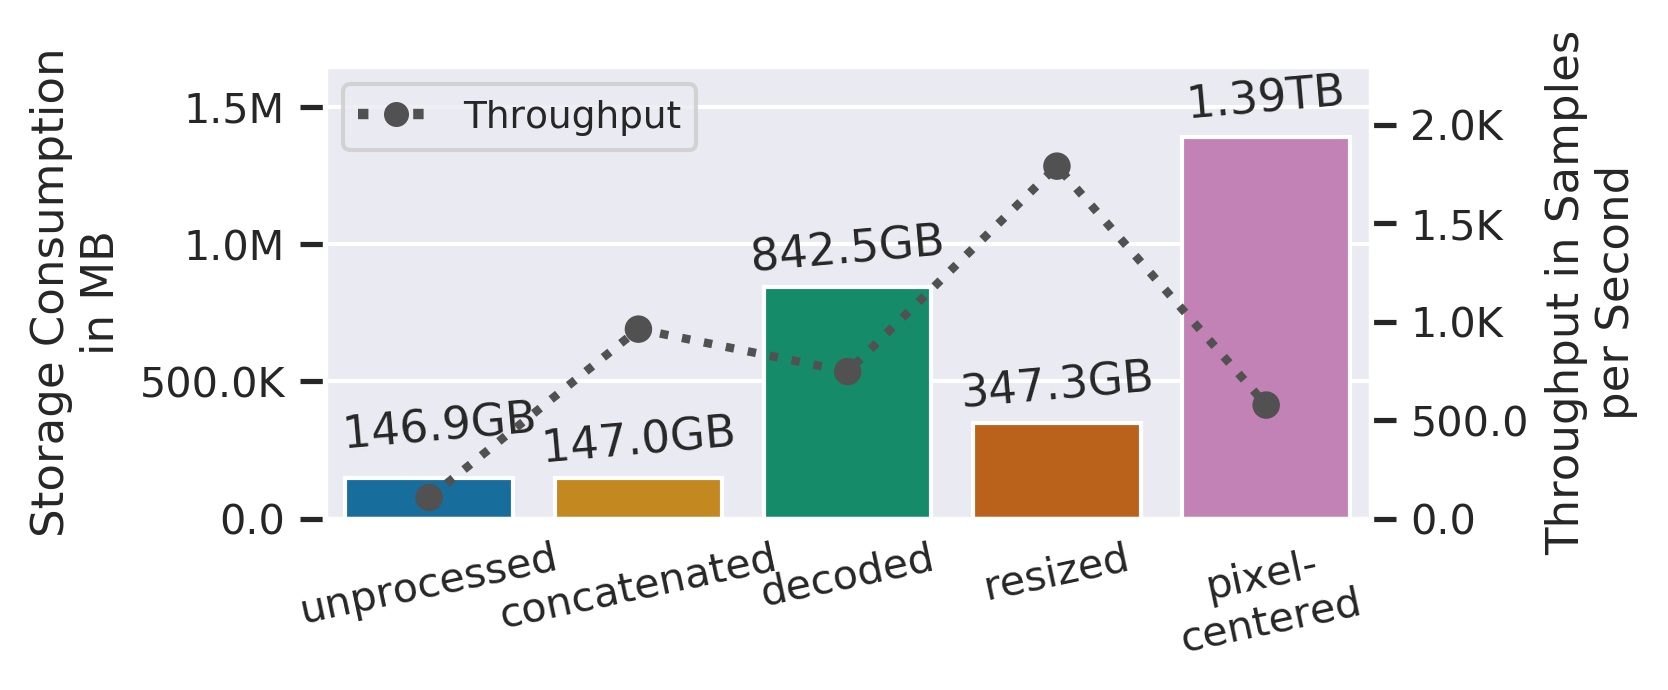

In [7]:
cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 \
                         and runs_count==0")

sample_size_mb_dict = {
    "500": 58.42
  , "1000": 116.84
  , "2000": 233.68
  , "4000": 467.35
  , "8000": 934.71
  , f"{full_dataset_samplecount}": 146899.991342
}

storage_consumption_comparison = {
    "storage_consumption_mb": []
  , "sample_count": []
  , "strategy": []
}

def add_to_dict(size, sample_count, label):
    '''Short helper'''
    storage_consumption_comparison["storage_consumption_mb"] += [size]
    storage_consumption_comparison["sample_count"] += [sample_count]
    storage_consumption_comparison["strategy"] += [label]
    
for sample_count in cum_df_temp.sample_count.unique():
    for i, strategy in enumerate(strategies):
        shard_sizes_mb = cum_df_temp.query(f"split_name=='{strategy}' and sample_count=={sample_count}")["shard_cum_size_MB"].to_numpy()
        for size_mb in shard_sizes_mb:
            if i == 0: # i.e., unprocessed
                size_mb = sample_size_mb_dict[str(sample_count)]
            add_to_dict(size = size_mb
                      , sample_count = sample_count
                      , label = strategies[i])

storage_df = pd.DataFrame(storage_consumption_comparison)

from matplotlib.lines import Line2D

sns.set(palette=default_palette, font_scale=0.9)
throughput_color = "#515151"
marker = 'o'
linestyle = ":"

fig, ax1 = plt.subplots(figsize=(4.5,2))
ax2 = ax1.twinx()

## throughput plot
plot2 = sns.pointplot(x="split_name", y="throughput_sps", data=cum_df_temp,
                      ax=ax2, scale=0.75, color=throughput_color, linestyles=linestyle, ci=0.95, marker='o')

plot2.set(ylabel="Throughput in Samples\nper Second")
plot2.set_xticklabels(
    strategies_renamed
  , rotation=20
)
ax2.grid(False)
legend_elements = [Line2D([0], [0], marker=marker, markersize=5, color=throughput_color, lw=2.5, label='Throughput', linestyle=linestyle)]
ax2.legend(handles=legend_elements, loc="upper left", prop={'size': 9})
plot2.set(ylim=(0, 2300))          

plot = sns.barplot(
        x="strategy",
        y="storage_consumption_mb",
        data=storage_df.query(f"sample_count=={500}"),
        ax=ax1
    )
plot.set_xticklabels(
    strategies_renamed
  , rotation=12
)
plot.tick_params(axis='x', which='major', pad=-1.5)
show_values_on_bars(plot, h_v="v", space=120000, rotation=5, additional_x_space=[0.05,0,0,0,0]
                                                            , additional_space=[50000,0,0,0,0], storage_formatting=True)
plot.set(ylabel="Storage Consumption\nin MB", xlabel="")
plot.set(ylim=(0, 1650000))

plot.yaxis.set_major_formatter(make_big_number_prettier)
plot2.yaxis.set_major_formatter(make_big_number_prettier)
save_fig("storage-vs-throughput")

# 2. Caching Analysis
### Full dataset, 8 threads, epoch 0 + 1 + 2

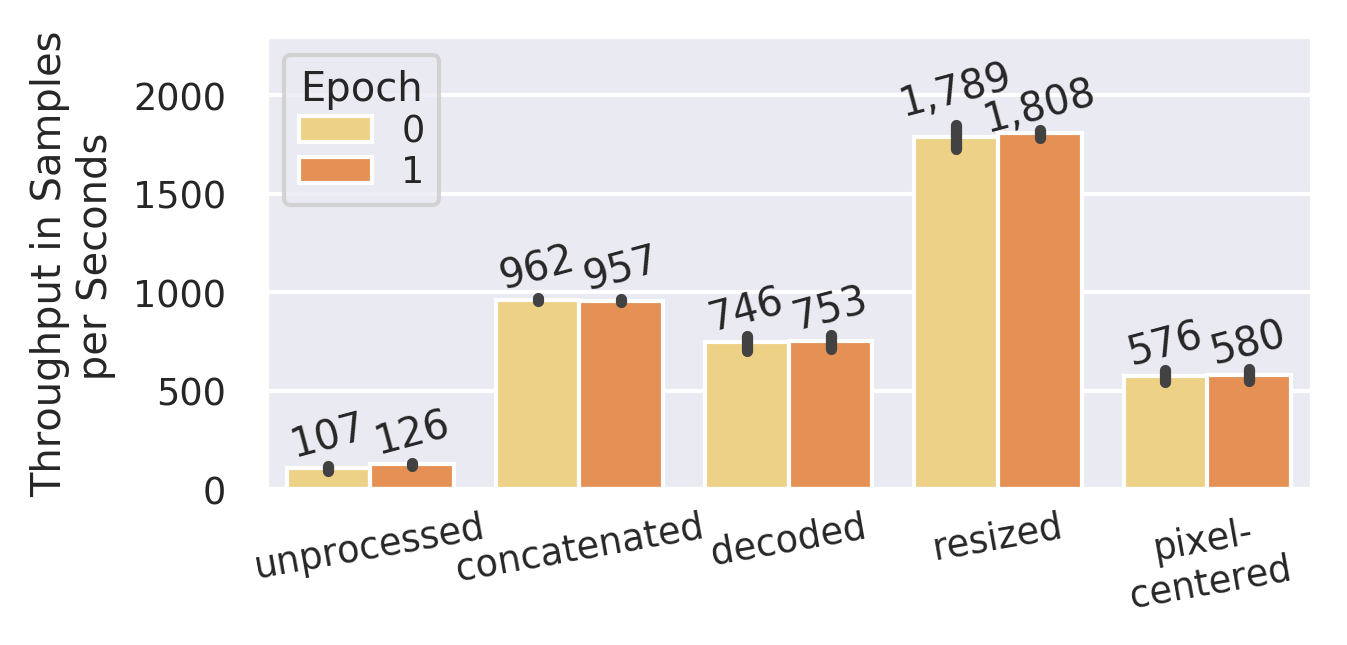

In [8]:
sns.set(palette=epoch_palette, font_scale=0.8)

cum_df_temp = cum_df.query(f"sample_count=={full_dataset_samplecount} \
                         and thread_count==8 and runs_count<=1")

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="split_name",
    y="throughput_sps",
    hue="runs_count",
    data=cum_df_temp
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
plot.set(xlabel="", ylabel="Throughput in Samples\n per Seconds")
plot.set(ylim=(0, 2300))
plot.legend(title="Epoch", ncol=1, labelspacing=0.1, loc="upper left")
show_values_on_bars(plot, h_v="v", space=150, rotation=15, additional_space=[0,0,0,100,0
                                                                            ,0,0,0,0,0])
save_fig("caching-over-epochs")

# 3. Compression Analysis (other notebook)

# 4. Number of Samples


### Normalizing the processing time per samples and renaming the maximum sample count to "full"

In [9]:
# calculate the per sample processing time for both offline and online processing
cum_df["per_sample_online_processing_time_s"] = cum_df["online_processing_time_s"] / cum_df["sample_count"]
cum_df["per_sample_offline_processing_and_save_time_s"] = cum_df["offline_processing_and_save_time_s"] / cum_df["sample_count"]
# calculate the total processing time for each sample count
cum_df["total_processing_time_s"] = cum_df["online_processing_time_s"] + cum_df["offline_processing_and_save_time_s"]
# extrapolate based on the full count of images
cum_df["full_dataset_online_processing_time_s"] = cum_df["per_sample_online_processing_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_s"] = cum_df["per_sample_offline_processing_and_save_time_s"] * full_dataset_samplecount
cum_df["full_dataset_offline_processing_and_save_time_m"] = cum_df["full_dataset_offline_processing_and_save_time_s"] / 60
cum_df["full_dataset_offline_processing_and_save_time_h"] = cum_df["full_dataset_offline_processing_and_save_time_m"] / 60


# sum the offline and online time for the full dataset processing time (converted to hours)
cum_df["full_dataset_processing_time_s"] = cum_df["full_dataset_online_processing_time_s"] + cum_df["full_dataset_offline_processing_and_save_time_s"]
cum_df["full_dataset_processing_time_m"] = cum_df["full_dataset_processing_time_s"] / 60
cum_df["full_dataset_processing_time_h"] = cum_df["full_dataset_processing_time_m"] / 60 


cum_df_mod = cum_df.copy(deep=True)
cum_df_mod.loc[cum_df_mod.sample_count == 1281167, 'sample_count'] = '1.3M (full)'
order_dict = { 500: 10, 1000: 11, 2000: 12, 4000: 13, 8000: 14, '1.3M (full)': 15}
strategy_order_dict = dict(list(enumerate(strategies)))
strategy_order_dict = dict({(y, x) for x, y in strategy_order_dict.items()})
order_dict.update(strategy_order_dict)
cum_df_mod = cum_df_mod.sort_values(by=['split_name', 'sample_count'], key=lambda x: x.map(order_dict))

# 5. Speedup
## 8000 samples + 1, 2, 4, 8 threads + epoch 0
### Calculate the speedup 

In [12]:
cum_8000_df = cum_df_mod.query("sample_count==8000")

parallel_capability = {
      "thread_count": []
    , "strategy": []
    , "speedup": []
    , "run": []
}

def add_capability(thread_count, strategy, speedup, run):
    parallel_capability["thread_count"] += [thread_count]
    parallel_capability["strategy"] += [strategy]
    parallel_capability["speedup"] += [speedup]
    parallel_capability["run"] += [run]

for strategy in strategies:
    for run_count in cum_df.runs_count.unique():
        for thread_count in cum_df.thread_count.unique():
            throughputs = cum_8000_df.query(f"thread_count=={thread_count} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].to_numpy()
            for throughput in throughputs:
                avg_step_t1_throughput = cum_8000_df.query(f"thread_count=={1} and split_name=='{strategy}' and runs_count=={run_count}")["throughput_sps"].mean()
                # not using percentages here as I feel its more intuitive, benchmarking crimes is still followed from my understanding
                #if avg_step_t1_throughput < throughput:
                #    rel_increase_factor =  throughput / avg_step_t1_throughput - 1
                #    add_capability(thread_count, strategy, np.round(rel_increase_factor, 2))
                #else:
                #    rel_decrease_factor = 1 - throughput / avg_step_t1_throughput
                #    add_capability(thread_count, strategy, -np.round(rel_decrease_factor, 2))
                ## now using speedup instead of increase/decrease factor
                speedup = throughput / avg_step_t1_throughput
                add_capability(thread_count, strategy, speedup, run_count)

parallel_capability_df = pd.DataFrame(parallel_capability)
parallel_capability_df

,thread_count,strategy,speedup,run
0,1,0-fully-online,1.049932,0
1,1,0-fully-online,1.005909,0
2,1,0-fully-online,0.993096,0
3,1,0-fully-online,0.975591,0
4,1,0-fully-online,0.975471,0
...,...,...,...,...
295,4,5-center-pixel-values,2.108041,1
296,4,5-center-pixel-values,2.317847,1
297,4,5-center-pixel-values,2.096757,1
298,4,5-center-pixel-values,2.113811,1


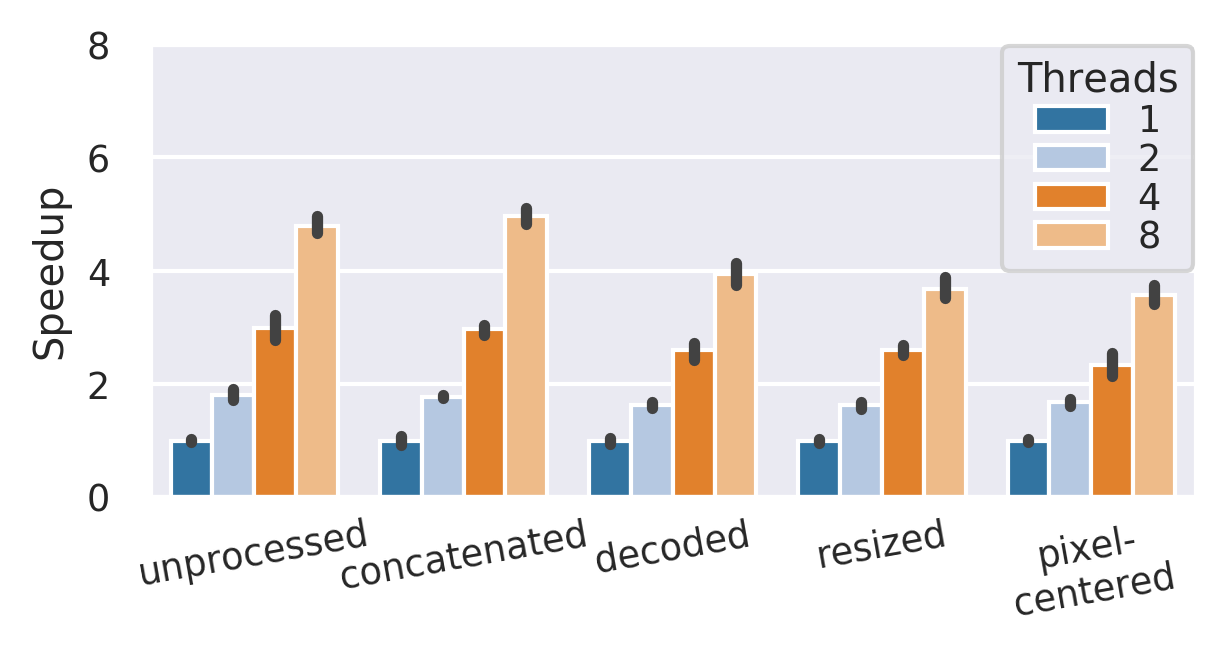

In [13]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==0")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-0")

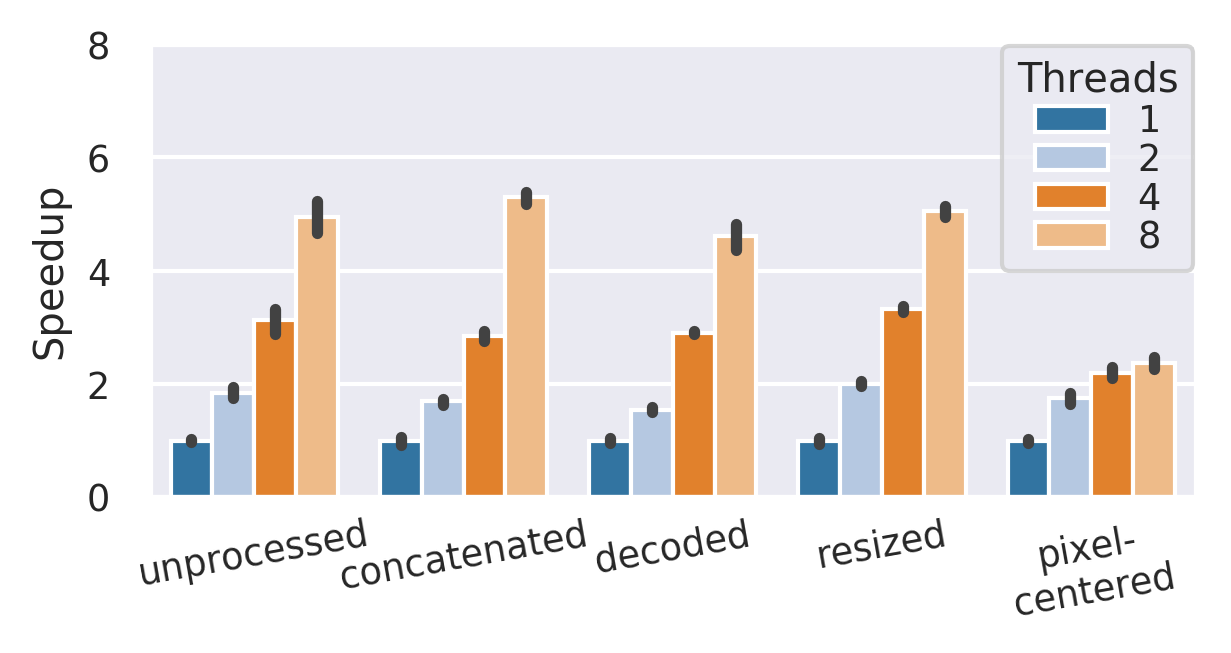

In [14]:
sns.set(palette=threads_palette, font_scale=0.8)

plt.figure(figsize=(4.5,2))
plot = sns.barplot(
    x="strategy",
    y="speedup",
    hue="thread_count",
    data=parallel_capability_df.query("run==1")
)
plot.set_xticklabels(
    strategies_renamed
  , rotation=10
)
plot.tick_params(axis='x', which='major', pad=-1.5)
#plot.set_title(f"Caching Speedup")
plot.set(xlabel="", ylabel="Speedup")
plot.set(ylim=(0, 8))
plot.legend(title="Threads", ncol=1,labelspacing=0.05, loc=(0.815,0.5))
save_fig("speedup-8000-samples-epoch-1")

# X. Misc Plots and Calculations

## X.1 Calculation for the Introduction - unprocessed vs resized

In [26]:
unprocessed='0-fully-online'
concatenated='2-read-image'
resized='4-resize-image'
pixel_centered='5-center-pixel-values'
unprocessed_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{unprocessed}' and runs_count==0")["throughput_sps"].mean()
concatenated_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{concatenated}' and runs_count==0")["throughput_sps"].mean()
resized_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{resized}' and runs_count==0")["throughput_sps"].mean()
full_mean_throughput = cum_df.query(f"sample_count=={full_dataset_samplecount} and thread_count==8 and split_name=='{pixel_centered}' and runs_count==0")["throughput_sps"].mean()
print(f"Unprocessed    strategy throughput (8 threads):  {np.round(unprocessed_mean_throughput,0)} sps")
print(f"Concatenated   strategy throughput (8 threads):  {np.round(concatenated_mean_throughput,0)} sps")
print(f"Resized        strategy throughput (8 threads): {np.round(resized_mean_throughput,0)} sps")
print(f"Pixel-centered strategy throughput (8 threads):  {np.round(full_mean_throughput,0)} sps")

Unprocessed    strategy throughput (8 threads):  107.0 sps
Concatenated   strategy throughput (8 threads):  962.0 sps
Resized        strategy throughput (8 threads): 1790.0 sps
Pixel-centered strategy throughput (8 threads):  577.0 sps


## X.2 Calculation for Analysis - Network Throughput for Unprocessed vs Concatinated

In [17]:
run = 0
threads = 8
sample_count = full_dataset_samplecount

def extract_online_processing_frames(split_name):
    '''
    '''    
    
    max_offline_processing_time_s = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["offline_processing_and_save_time_s"].max()
    
    filtered_dstat_df = cum_dstat_df.query(
        f"split_name=='{split_name}' and \
          run=={run} and \
          thread_count=={threads} and \
          rel_time_s>={max_offline_processing_time_s}")
    
    return filtered_dstat_df

split_names = cum_df.split_name.unique()
frames = [extract_online_processing_frames(split_name=split_name) for split_name in split_names]
online_df = pd.concat(frames)

for split_name in cum_df.split_name.unique():
    
    avg_online_processing_time = cum_df.query(
        f"split_name=='{split_name}' and \
          runs_count=={run} and \
          thread_count=={threads} and \
          sample_count=={sample_count}")["online_processing_time_s"].describe().iloc[1]
    
    
    print("---------------------------------------")
    print(f"-- {split_name} Network Read in MB/s --")
    print(f"-- {split_name} Online Processing time: {int(avg_online_processing_time)}")
    
    temp_df = online_df.query(f"split_name=='{split_name}'")
    print(temp_df.describe()["net_read_mbs"].iloc[1])

---------------------------------------
-- 0-fully-online Network Read in MB/s --
-- 0-fully-online Online Processing time: 12158
12.287014961242676
---------------------------------------
-- 2-read-image Network Read in MB/s --
-- 2-read-image Online Processing time: 1331
111.27703094482422
---------------------------------------
-- 3-decode-image Network Read in MB/s --
-- 3-decode-image Online Processing time: 1722
490.6575927734375
---------------------------------------
-- 4-resize-image Network Read in MB/s --
-- 4-resize-image Online Processing time: 716
469.9493408203125
---------------------------------------
-- 5-center-pixel-values Network Read in MB/s --
-- 5-center-pixel-values Online Processing time: 2231
585.87841796875
